<a href="https://colab.research.google.com/github/Covpet/ENHANCING-PLANT-DISEASE-DETECTION-WITH-DEEP-LEARNING-MODELS/blob/main/plant_disease_detection_(cassava_and_maize).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import cv2

import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import pandas as pd
import shutil
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Displaying images from folder: fall armyworm


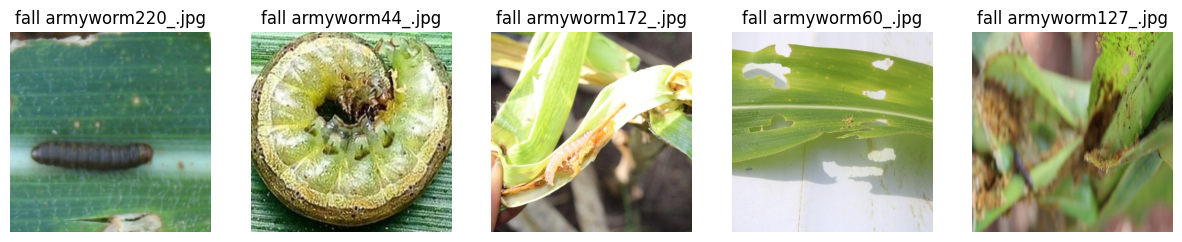

Displaying images from folder: grasshoper


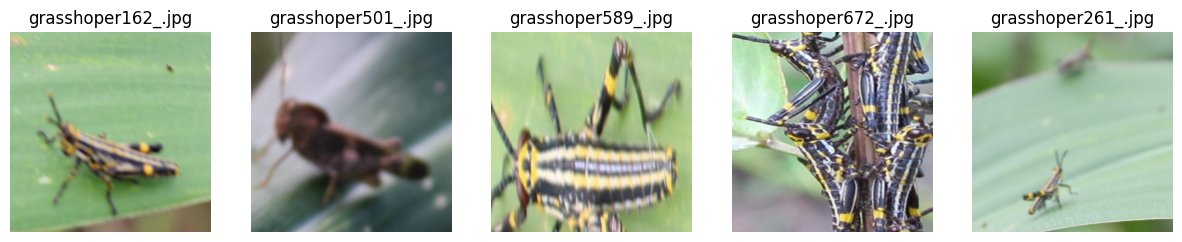

Displaying images from folder: healthy


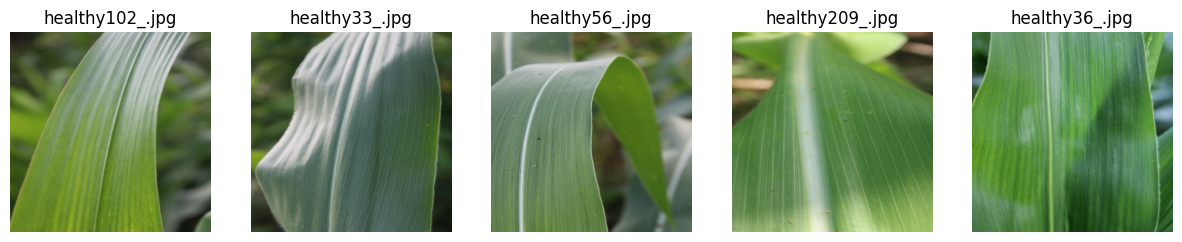

Displaying images from folder: leaf beetle


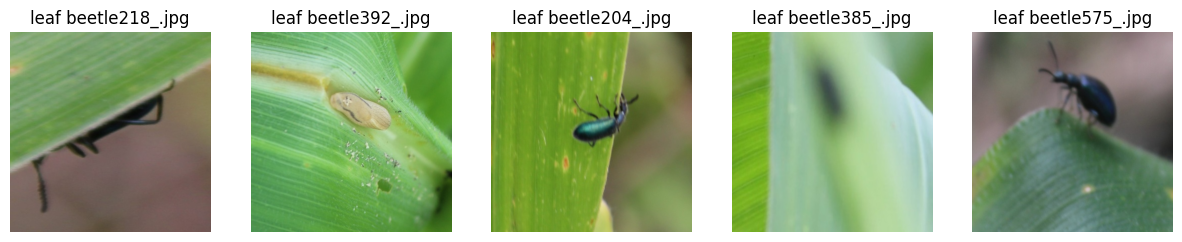

Displaying images from folder: leaf blight


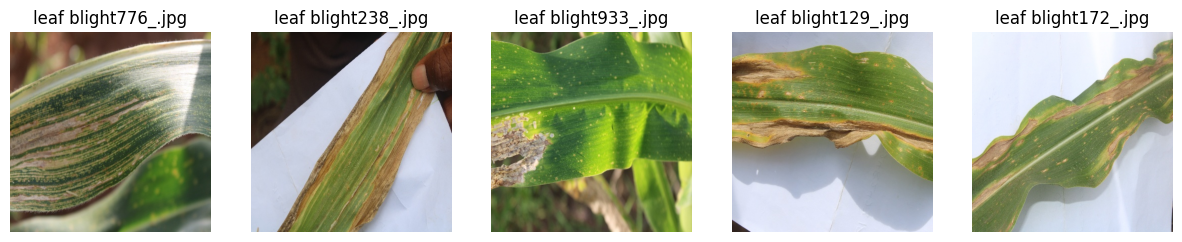

Displaying images from folder: leaf spot


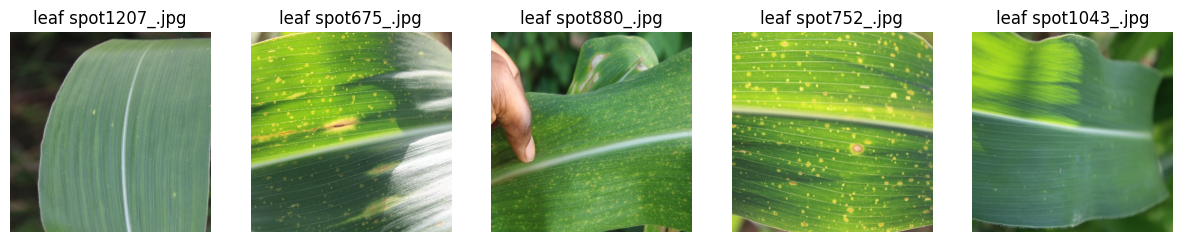

Displaying images from folder: streak virus


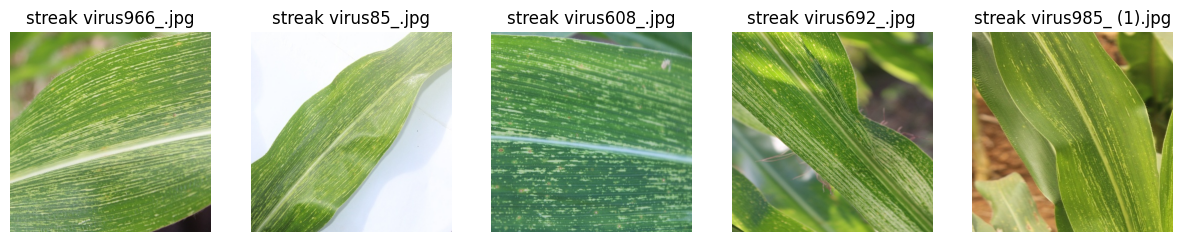

In [4]:
# Define base directory and folder names
base_dir = '/content/drive/MyDrive/Raw Data/CCMT Dataset/Maize'
folders = ['fall armyworm', 'grasshoper', 'healthy', 'leaf beetle', 'leaf blight', 'leaf spot', 'streak virus']

# Function to check if a file is a valid image
def is_valid_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verify if the file is a valid image
        return True
    except (IOError, SyntaxError) as e:
        return False

# Function to remove invalid image files
def remove_invalid_images(folder_path):
    files = os.listdir(folder_path)
    for file in files:
        file_path = os.path.join(folder_path, file)
        if not is_valid_image(file_path):
            print(f"Removing invalid file: {file}")
            os.remove(file_path)

# Function to display a sample of 5 images from each folder
def display_images_from_folders(base_dir, folders, num_images=5):
    for folder in folders:
        folder_path = os.path.join(base_dir, folder)
        print(f"Displaying images from folder: {folder}")

        # Remove invalid images before displaying
        remove_invalid_images(folder_path)

        # Get all valid image files in the folder after cleanup
        files = [f for f in os.listdir(folder_path) if is_valid_image(os.path.join(folder_path, f))]

        if len(files) < num_images:
            print(f"Not enough valid images in {folder}. Found only {len(files)} valid images.")
            continue

        # Randomly select images to display
        selected_files = random.sample(files, num_images)

        # Create a subplot to display images
        fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

        for i, file in enumerate(selected_files):
            img_path = os.path.join(folder_path, file)
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(file)

        plt.show()

# Call the function to display images and remove invalid ones
display_images_from_folders(base_dir, folders)

                                          image_path             class
0  /content/drive/MyDrive/Raw Data/CCMT Dataset/C...  bacterial blight
1  /content/drive/MyDrive/Raw Data/CCMT Dataset/C...  bacterial blight
2  /content/drive/MyDrive/Raw Data/CCMT Dataset/C...  bacterial blight
3  /content/drive/MyDrive/Raw Data/CCMT Dataset/C...  bacterial blight
4  /content/drive/MyDrive/Raw Data/CCMT Dataset/C...  bacterial blight


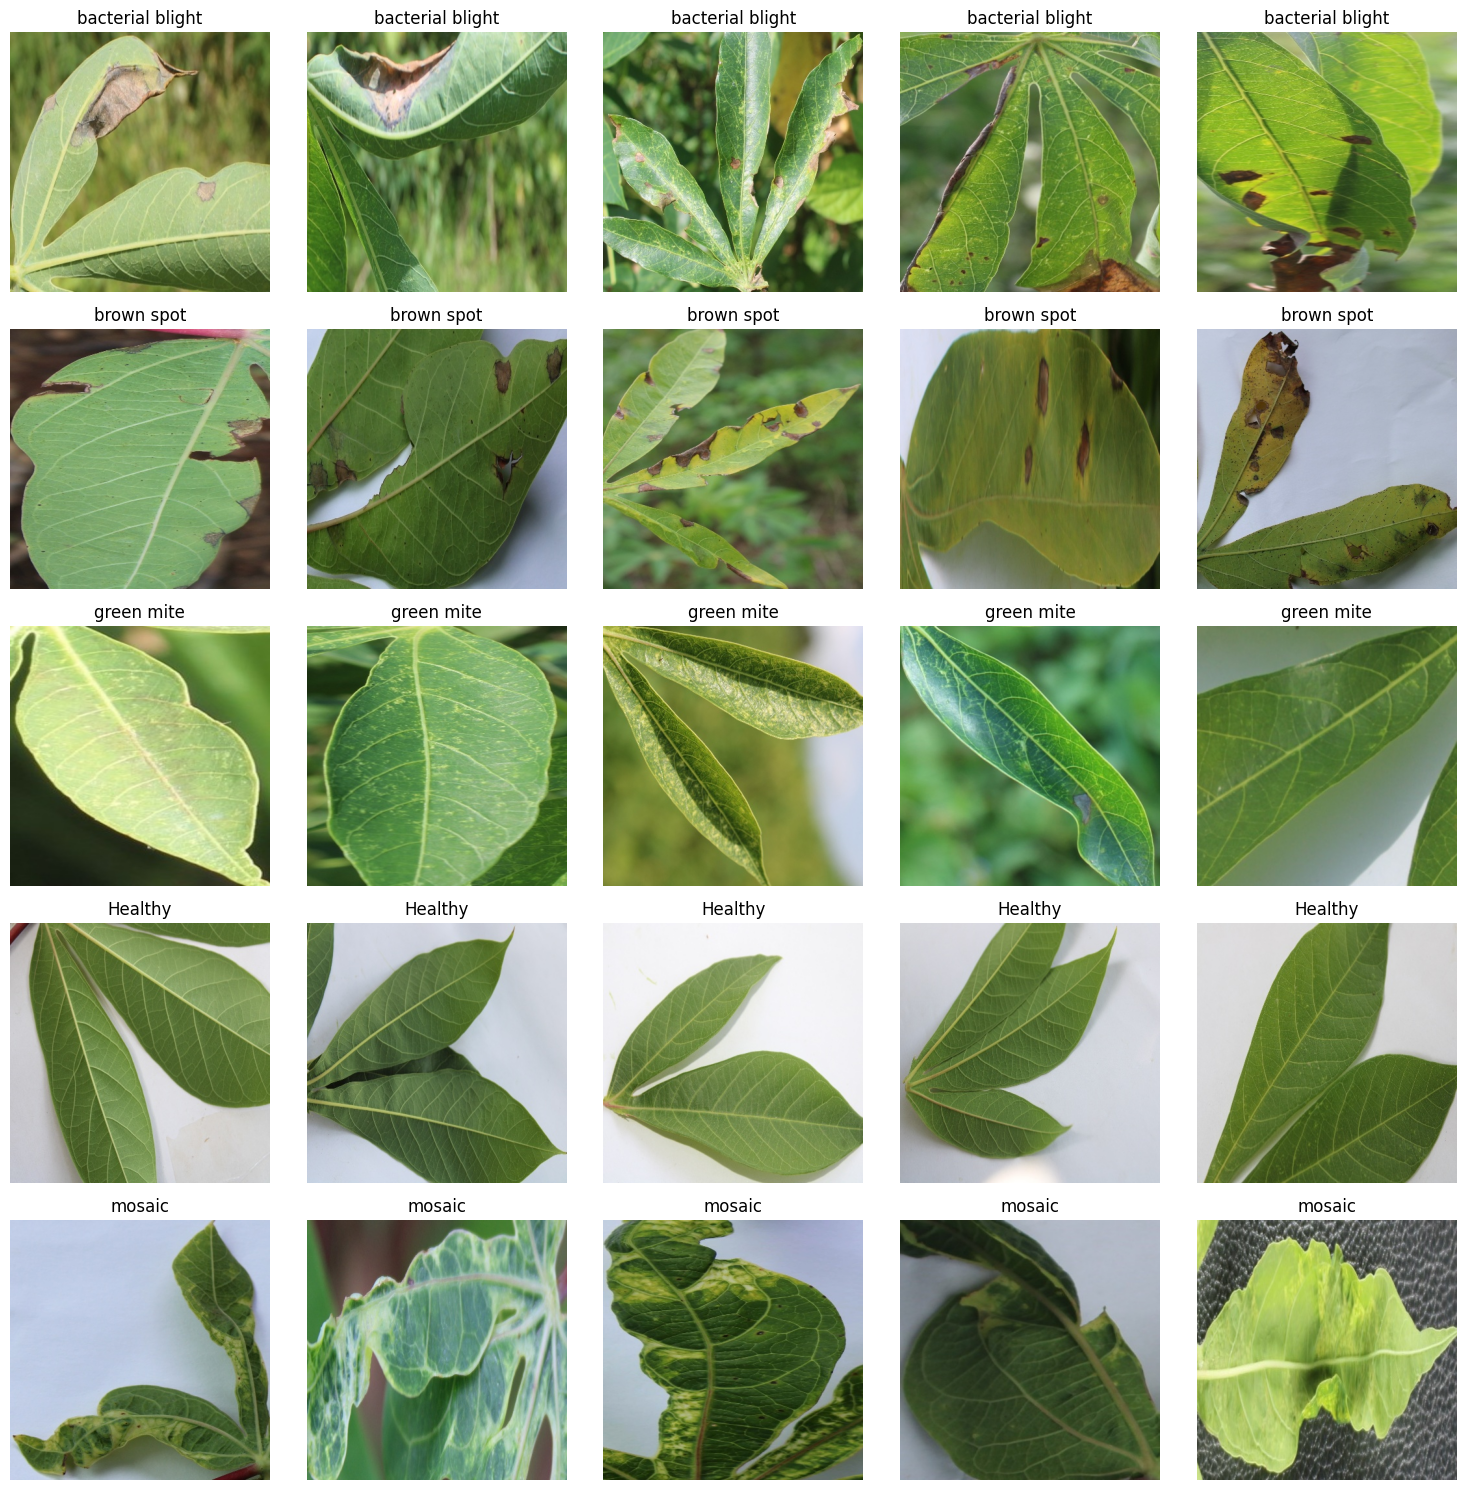

In [5]:
# Directory structure
base_dir = '/content/drive/MyDrive/Raw Data/CCMT Dataset/Cassava'
folders = [
    'bacterial blight', 'brown spot', 'green mite', 'Healthy', 'mosaic']

# List to store image paths and their corresponding classes
image_paths = []
image_classes = []

# Iterate through each folder and collect image paths
for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):  # Adjust if necessary for different image formats
            image_paths.append(os.path.join(folder_path, filename))
            image_classes.append(folder)

# Create a DataFrame
df_images = pd.DataFrame({
    'image_path': image_paths,
    'class': image_classes
})

# Show the DataFrame with image paths and their classes
print(df_images.head())

# Set up a plot to display the images
num_images_per_class = 5  # Show 5 images per class
fig, axes = plt.subplots(nrows=len(folders), ncols=num_images_per_class, figsize=(15, 15))

# Loop through each class and display 5 images
for i, folder in enumerate(folders):
    # Filter images of the current class
    class_images = df_images[df_images['class'] == folder].head(num_images_per_class)

    for j, (image_path, label) in enumerate(zip(class_images['image_path'], class_images['class'])):
        img = Image.open(image_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        axes[i, j].set_title(label)

plt.tight_layout()
plt.show()

In [6]:
# Function to load and prepare the DataFrame
def load_data(base_dir, folders):
    image_paths = []
    image_classes = []

    # Iterate through each folder and collect image paths
    for folder in folders:
        folder_path = os.path.join(base_dir, folder)
        for filename in os.listdir(folder_path):
            if filename.endswith(('.png', '.jpg', '.jpeg')):  # Adjust if necessary for different image formats
                image_paths.append(os.path.join(folder_path, filename))
                image_classes.append(folder)

    # Create a DataFrame
    df_images = pd.DataFrame({
        'image_path': image_paths,
        'class': image_classes
    })

    return df_images

In [7]:
# Function to load and prepare the DataFrame
def load_data(base_dir, folders):
    image_paths = []
    image_classes = []

    # Iterate through each folder and collect image paths
    for folder in folders:
        folder_path = os.path.join(base_dir, folder)
        for filename in os.listdir(folder_path):
            if filename.endswith(('.png', '.jpg', '.jpeg')):  # Adjust if necessary for different image formats
                image_paths.append(os.path.join(folder_path, filename))
                image_classes.append(folder)

    # Create a DataFrame
    df_images = pd.DataFrame({
        'image_path': image_paths,
        'class': image_classes
    })

    return df_images

# For Maize
base_dir_maize = '/content/drive/MyDrive/Raw Data/CCMT Dataset/Maize'
folders_maize = [
    'fall armyworm', 'grasshoper', 'healthy', 'leaf beetle', 'leaf blight', 'leaf spot', 'streak virus'
]

df_maize = load_data(base_dir_maize, folders_maize)

# For Cassava
base_dir_cassava = '/content/drive/MyDrive/Raw Data/CCMT Dataset/Cassava'
folders_cassava = [
    'bacterial blight', 'brown spot', 'green mite', 'Healthy', 'mosaic'
]

df_cassava = load_data(base_dir_cassava, folders_cassava)

# Count the number of images per class
maize_class_counts = df_maize['class'].value_counts()
cassava_class_counts = df_cassava['class'].value_counts()

# Count the file formats for both datasets
maize_file_formats = df_maize['image_path'].apply(lambda x: x.split('.')[-1]).value_counts()
cassava_file_formats = df_cassava['image_path'].apply(lambda x: x.split('.')[-1]).value_counts()

# Display counts for Maize
print("Maize Class Counts:")
print(maize_class_counts)
print("\nMaize File Format Counts:")
print(maize_file_formats)

# Display counts for Cassava
print("\nCassava Class Counts:")
print(cassava_class_counts)
print("\nCassava File Format Counts:")
print(cassava_file_formats)

Maize Class Counts:
class
leaf spot        1249
streak virus     1002
leaf blight       998
leaf beetle       938
grasshoper        683
fall armyworm     285
healthy           206
Name: count, dtype: int64

Maize File Format Counts:
image_path
jpg    5361
Name: count, dtype: int64

Cassava Class Counts:
class
bacterial blight    2772
brown spot          1506
Healthy             1283
mosaic              1235
green mite          1154
Name: count, dtype: int64

Cassava File Format Counts:
image_path
jpg    7950
Name: count, dtype: int64


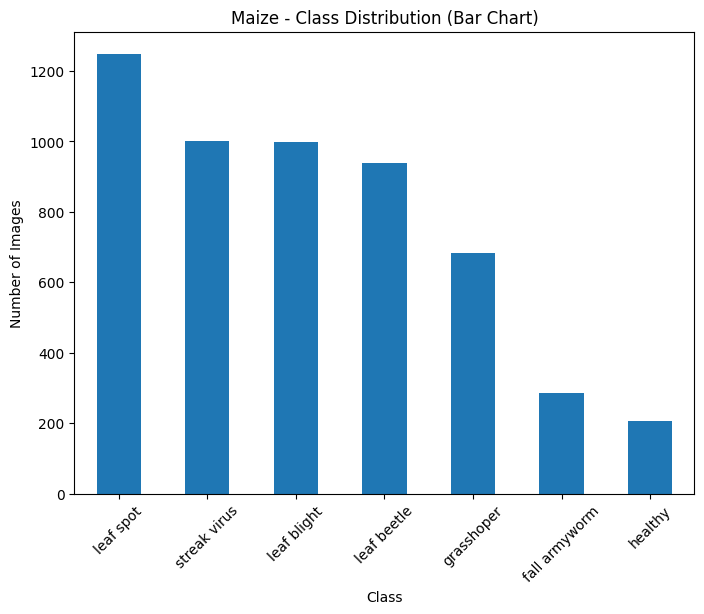

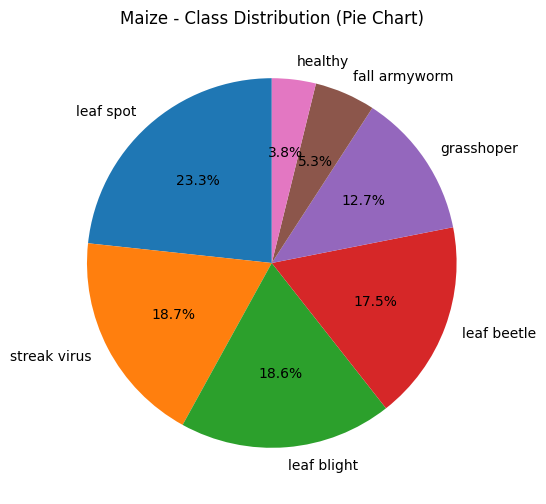

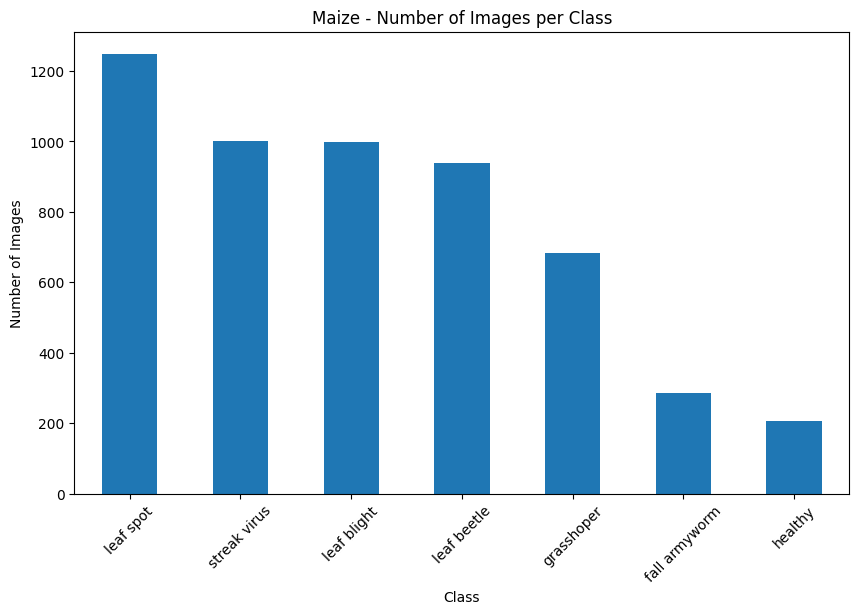

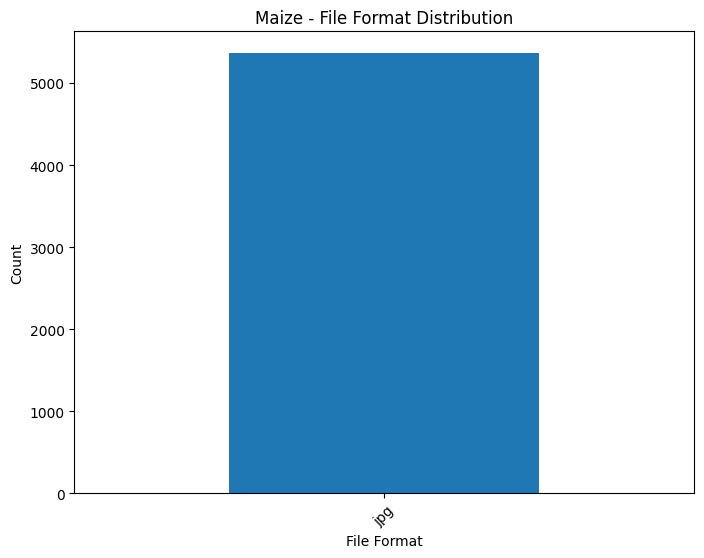

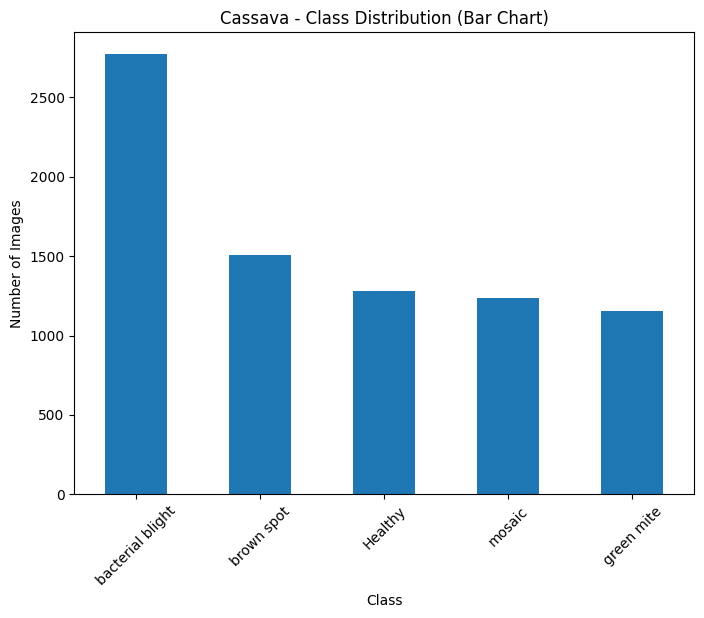

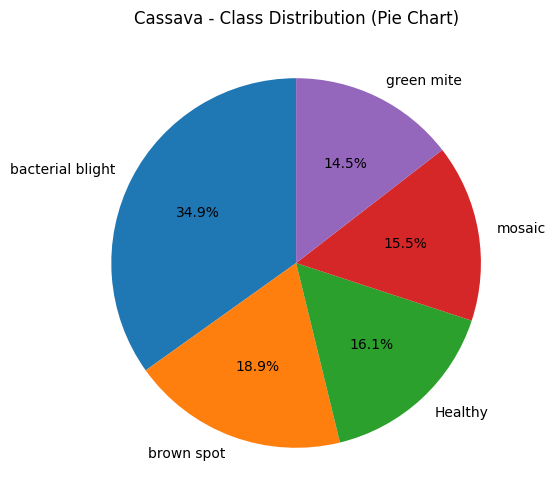

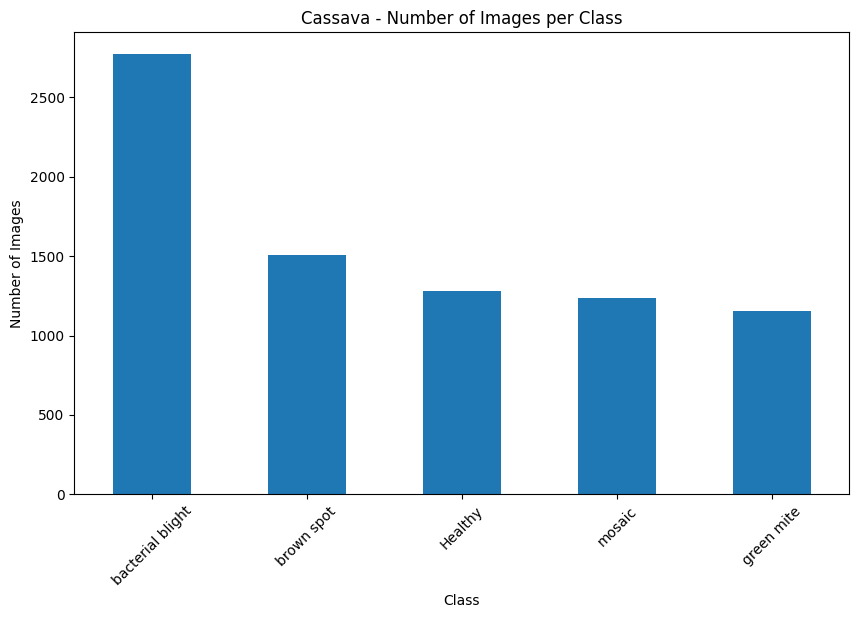

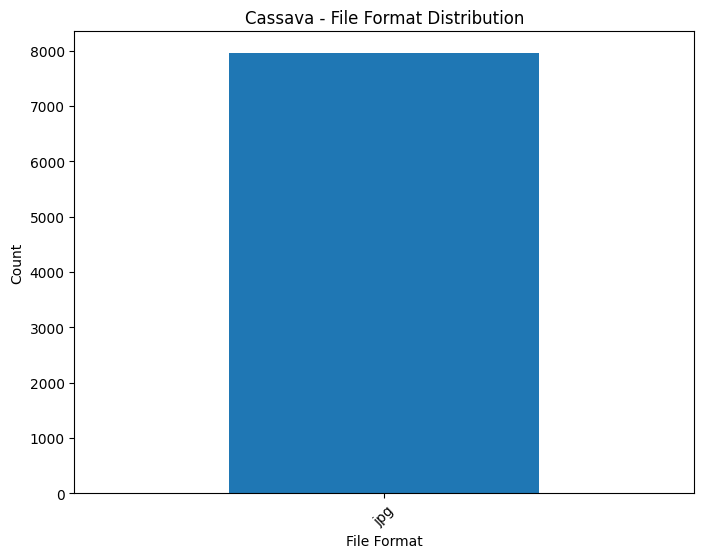

In [8]:
# For Maize
base_dir_maize = '/content/drive/MyDrive/Raw Data/CCMT Dataset/Maize'
folders_maize = [
    'fall armyworm', 'grasshoper', 'healthy', 'leaf beetle', 'leaf blight', 'leaf spot', 'streak virus'
]

df_maize = load_data(base_dir_maize, folders_maize)

# For Cassava
base_dir_cassava = '/content/drive/MyDrive/Raw Data/CCMT Dataset/Cassava'
folders_cassava = [
    'bacterial blight', 'brown spot', 'green mite', 'Healthy', 'mosaic'
]

df_cassava = load_data(base_dir_cassava, folders_cassava)

# EDA for Maize dataset
def plot_eda(df_images, title):
    # Class distribution (Bar Chart)
    plt.figure(figsize=(8, 6))
    df_images['class'].value_counts().plot(kind='bar')
    plt.title(f'{title} - Class Distribution (Bar Chart)')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

    # Class distribution (Pie Chart)
    plt.figure(figsize=(8, 6))
    df_images['class'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
    plt.title(f'{title} - Class Distribution (Pie Chart)')
    plt.ylabel('')
    plt.show()

    # Number of Images per Class (Bar Chart)
    class_counts = df_images['class'].value_counts()
    class_counts.plot(kind='bar', figsize=(10, 6))
    plt.title(f'{title} - Number of Images per Class')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

    # File Format Distribution (Bar Chart)
    file_formats = df_images['image_path'].apply(lambda x: x.split('.')[-1]).value_counts()
    file_formats.plot(kind='bar', figsize=(8, 6))
    plt.title(f'{title} - File Format Distribution')
    plt.xlabel('File Format')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

# Plot EDA for Maize dataset
plot_eda(df_maize, 'Maize')

# Plot EDA for Cassava dataset
plot_eda(df_cassava, 'Cassava')

In [9]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

                                          image_path                class
0  /content/drive/MyDrive/Raw Data/CCMT Dataset/M...  maize_fall armyworm
1  /content/drive/MyDrive/Raw Data/CCMT Dataset/M...  maize_fall armyworm
2  /content/drive/MyDrive/Raw Data/CCMT Dataset/M...  maize_fall armyworm
3  /content/drive/MyDrive/Raw Data/CCMT Dataset/M...  maize_fall armyworm
4  /content/drive/MyDrive/Raw Data/CCMT Dataset/M...  maize_fall armyworm


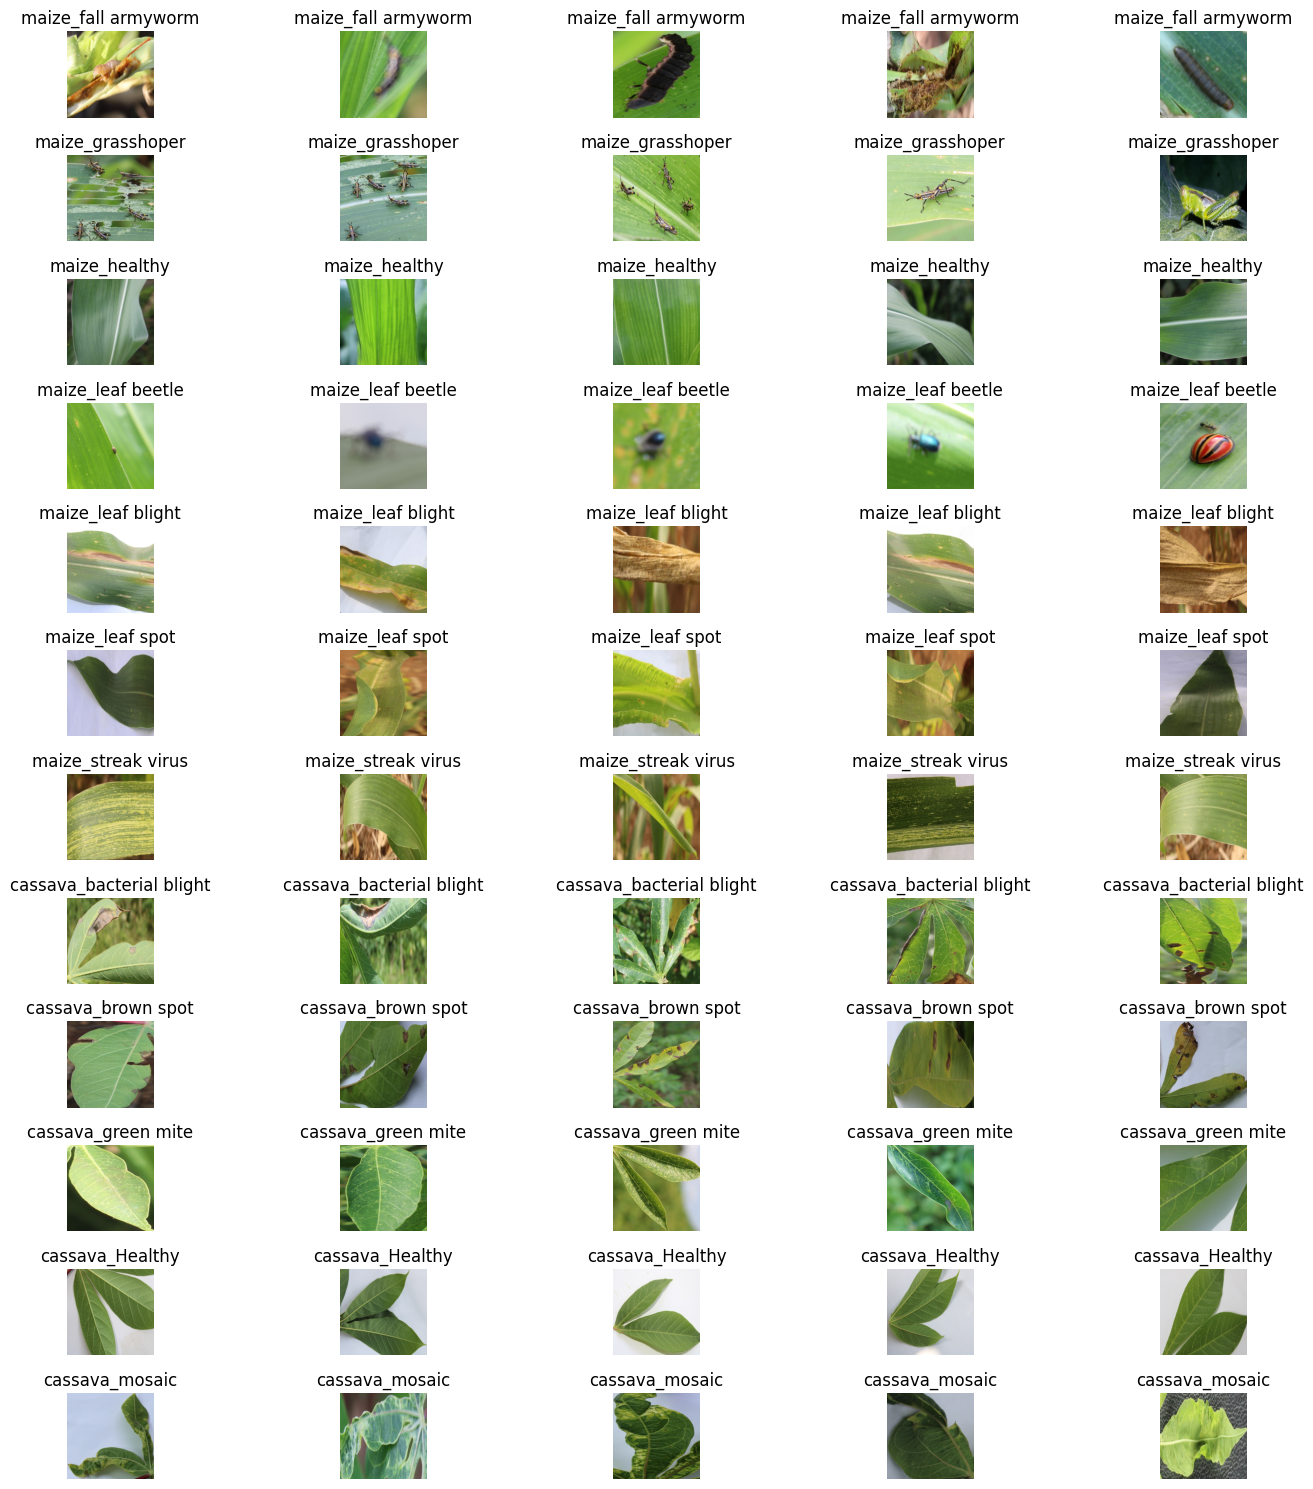

In [10]:
# Define base directories for both datasets
maize_base_dir = '/content/drive/MyDrive/Raw Data/CCMT Dataset/Maize'
cassava_base_dir = '/content/drive/MyDrive/Raw Data/CCMT Dataset/Cassava'

# Folder names for Maize dataset
maize_folders = ['fall armyworm', 'grasshoper', 'healthy', 'leaf beetle', 'leaf blight', 'leaf spot', 'streak virus']

# Folder names for Cassava dataset
cassava_folders = ['bacterial blight', 'brown spot', 'green mite', 'Healthy', 'mosaic']

# Function to check if a file is a valid image
def is_valid_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verify if the file is a valid image
        return True
    except (IOError, SyntaxError) as e:
        return False

# Function to remove invalid image files
def remove_invalid_images(folder_path):
    files = os.listdir(folder_path)
    for file in files:
        file_path = os.path.join(folder_path, file)
        if not is_valid_image(file_path):
            print(f"Removing invalid file: {file}")
            os.remove(file_path)

# Remove invalid images before training for both datasets
for folder in maize_folders:
    remove_invalid_images(os.path.join(maize_base_dir, folder))
for folder in cassava_folders:
    remove_invalid_images(os.path.join(cassava_base_dir, folder))

# Create a DataFrame for the images in both datasets
image_paths = []
image_classes = []

# Maize dataset
for folder in maize_folders:
    folder_path = os.path.join(maize_base_dir, folder)
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(folder_path, filename))
            image_classes.append(f"maize_{folder}")

# Cassava dataset
for folder in cassava_folders:
    folder_path = os.path.join(cassava_base_dir, folder)
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(folder_path, filename))
            image_classes.append(f"cassava_{folder}")

# Create a DataFrame
df_images = pd.DataFrame({
    'image_path': image_paths,
    'class': image_classes
})

# Show the DataFrame with image paths and their classes
print(df_images.head())

# Set up a plot to display the images
num_images_per_class = 5  # Show 5 images per class
fig, axes = plt.subplots(nrows=len(maize_folders) + len(cassava_folders), ncols=num_images_per_class, figsize=(15, 15))

# Loop through each class and display 5 images
for i, folder in enumerate(maize_folders + cassava_folders):
    # Filter images of the current class
    class_images = df_images[df_images['class'].str.contains(folder)].head(num_images_per_class)

    for j, (image_path, label) in enumerate(zip(class_images['image_path'], class_images['class'])):
        img = Image.open(image_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        axes[i, j].set_title(label)

plt.tight_layout()
plt.show()

In [11]:
unique_classes = df_images['class'].nunique()
print(f"Number of classes in the dataset: {unique_classes}")

Number of classes in the dataset: 12


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Combine the Maize and Cassava DataFrames
df_combined = pd.concat([df_maize, df_cassava], ignore_index=True)

# Split into training (80%), testing (10%), and validation (10%)
train_df, test_df = train_test_split(df_combined, test_size=0.2, stratify=df_combined['class'], random_state=42)
valid_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df['class'], random_state=42)

# Display the counts for each dataset to verify
print(f"Training set: {train_df.shape[0]} images")
print(f"Validation set: {valid_df.shape[0]} images")
print(f"Testing set: {test_df.shape[0]} images")

# Optional: Check the distribution of classes in each set
print("\nTraining set class distribution:")
print(train_df['class'].value_counts())

print("\nValidation set class distribution:")
print(valid_df['class'].value_counts())

print("\nTesting set class distribution:")
print(test_df['class'].value_counts())

Training set: 10648 images
Validation set: 1331 images
Testing set: 1332 images

Training set class distribution:
class
bacterial blight    2218
brown spot          1205
Healthy             1026
leaf spot            999
mosaic               988
green mite           923
streak virus         802
leaf blight          798
leaf beetle          750
grasshoper           546
fall armyworm        228
healthy              165
Name: count, dtype: int64

Validation set class distribution:
class
bacterial blight    277
brown spot          150
Healthy             128
leaf spot           125
mosaic              123
green mite          115
leaf blight         100
streak virus        100
leaf beetle          94
grasshoper           69
fall armyworm        29
healthy              21
Name: count, dtype: int64

Testing set class distribution:
class
bacterial blight    277
brown spot          151
Healthy             129
leaf spot           125
mosaic              124
green mite          116
leaf blight    

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Data generators to load and augment images in batches
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Assuming you have a function `flow_from_dataframe()` to load images from the DataFrame
# If your DataFrame contains the image paths and classes, you can use it in ImageDataGenerator.
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df, directory=None,
                                                    x_col='image_path', y_col='class',
                                                    target_size=(150, 150), batch_size=32,
                                                    class_mode='categorical')

valid_generator = valid_datagen.flow_from_dataframe(dataframe=valid_df, directory=None,
                                                    x_col='image_path', y_col='class',
                                                    target_size=(150, 150), batch_size=32,
                                                    class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(dataframe=test_df, directory=None,
                                                  x_col='image_path', y_col='class',
                                                  target_size=(150, 150), batch_size=32,
                                                  class_mode='categorical')

# Build the CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_df['class'].unique()), activation='softmax')  # Number of classes
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Define a checkpoint to save the best model during training
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Train the model
history = model.fit(train_generator, epochs=10, validation_data=valid_generator,
                    callbacks=[checkpoint])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.4f}")

Found 10648 validated image filenames belonging to 12 classes.
Found 1331 validated image filenames belonging to 12 classes.
Found 1332 validated image filenames belonging to 12 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.2042 - loss: 2.3698
Epoch 1: val_loss improved from inf to 1.98835, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 160s 476ms/step - accuracy: 0.2043 - loss: 2.3694 - val_accuracy: 0.2990 - val_loss: 1.9883
Epoch 2/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.2973 - loss: 1.9834
Epoch 2: val_loss improved from 1.98835 to 1.67118, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 157s 472ms/step - accuracy: 0.2973 - loss: 1.9833 - val_accuracy: 0.4050 - val_loss: 1.6712
Epoch 3/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.3606 - loss: 1.8071
Epoch 3: val_loss improved from 1.67118 to 1.45507, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 152s 454ms/step - accuracy: 0.3606 - loss: 1.8069 - val_accuracy: 0.4591 - val_loss: 1.4551
Epoch 4/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.4055 - loss: 1.6777
Epoch 4: val_loss improved from 1.45507 to 1.33691, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 147s 442ms/step - accuracy: 0.4055 - loss: 1.6775 - val_accuracy: 0.5244 - val_loss: 1.3369
Epoch 5/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.4658 - loss: 1.5101
Epoch 5: val_loss improved from 1.33691 to 1.15732, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 150s 451ms/step - accuracy: 0.4658 - loss: 1.5101 - val_accuracy: 0.5845 - val_loss: 1.1573
Epoch 6/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.5058 - loss: 1.4278
Epoch 6: val_loss improved from 1.15732 to 1.11649, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 154s 461ms/step - accuracy: 0.5057 - loss: 1.4278 - val_accuracy: 0.6153 - val_loss: 1.1165
Epoch 7/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.5324 - loss: 1.3540
Epoch 7: val_loss improved from 1.11649 to 1.06772, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 151s 453ms/step - accuracy: 0.5324 - loss: 1.3538 - val_accuracy: 0.6183 - val_loss: 1.0677
Epoch 8/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.5693 - loss: 1.2542
Epoch 8: val_loss improved from 1.06772 to 1.00015, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 150s 451ms/step - accuracy: 0.5693 - loss: 1.2542 - val_accuracy: 0.6349 - val_loss: 1.0001
Epoch 9/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.5781 - loss: 1.2004
Epoch 9: val_loss improved from 1.00015 to 0.88446, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 151s 454ms/step - accuracy: 0.5782 - loss: 1.2004 - val_accuracy: 0.6867 - val_loss: 0.8845
Epoch 10/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.6152 - loss: 1.1210
Epoch 10: val_loss improved from 0.88446 to 0.87931, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 154s 461ms/step - accuracy: 0.6152 - loss: 1.1211 - val_accuracy: 0.6860 - val_loss: 0.8793
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step - accuracy: 0.7095 - loss: 0.9031
Test accuracy: 0.7042


In [14]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

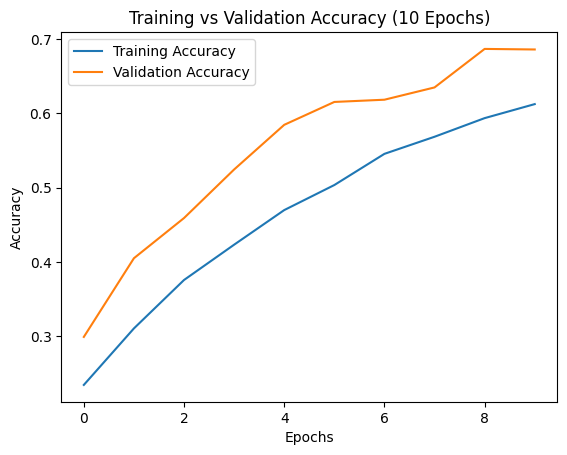

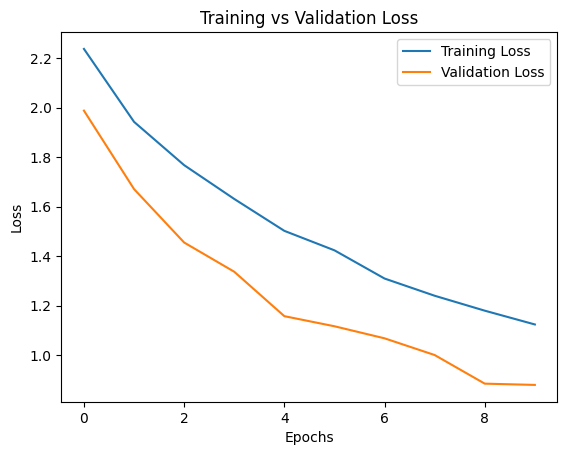

In [15]:
# Plot the training and validation accuracy fo 10 Epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (10 Epochs)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step
Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.10      0.10      0.10       129
bacterial blight       0.19      0.22      0.20       277
      brown spot       0.11      0.11      0.11       151
   fall armyworm       0.00      0.00      0.00        28
      grasshoper       0.00      0.00      0.00        68
      green mite       0.11      0.16      0.13       116
         healthy       0.00      0.00      0.00        20
     leaf beetle       0.05      0.05      0.05        94
     leaf blight       0.09      0.06      0.07       100
       leaf spot       0.12      0.14      0.13       125
          mosaic       0.14      0.12      0.13       124
    streak virus       0.07      0.07      0.07       100

        accuracy                           0.12      1332
       macro avg       0.08      0.09      0.08      1332
    weighted avg       0.11      0.12      0.11      1332



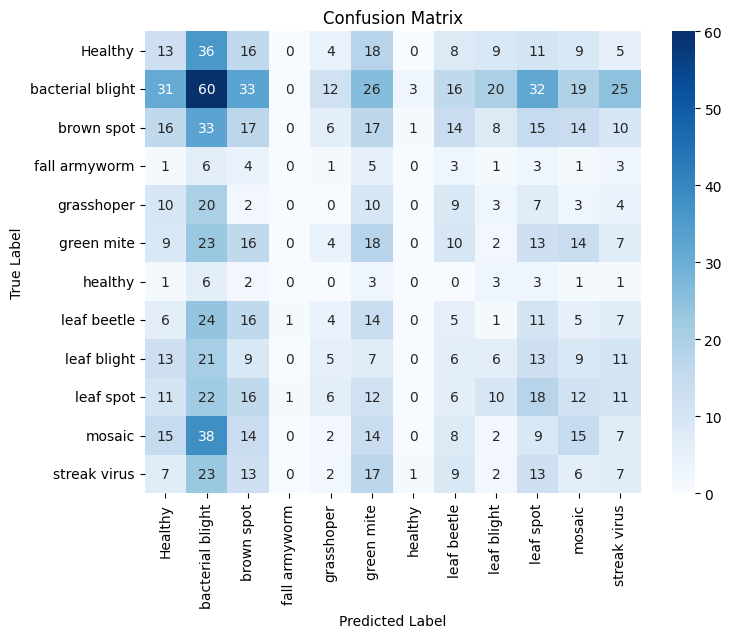

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Get the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Class labels

# Predict on the test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Generate classification report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Data generators to load and augment images in batches
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Assuming you have a function `flow_from_dataframe()` to load images from the DataFrame
# If your DataFrame contains the image paths and classes, you can use it in ImageDataGenerator.
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df, directory=None,
                                                    x_col='image_path', y_col='class',
                                                    target_size=(150, 150), batch_size=32,
                                                    class_mode='categorical')

valid_generator = valid_datagen.flow_from_dataframe(dataframe=valid_df, directory=None,
                                                    x_col='image_path', y_col='class',
                                                    target_size=(150, 150), batch_size=32,
                                                    class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(dataframe=test_df, directory=None,
                                                  x_col='image_path', y_col='class',
                                                  target_size=(150, 150), batch_size=32,
                                                  class_mode='categorical')

# Build the CNN Model
model2= Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_df['class'].unique()), activation='softmax')  # Number of classes
])

# Compile the model
model2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Define a checkpoint to save the best model during training
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Train the model
history2 = model2.fit(train_generator, epochs=20, validation_data=valid_generator,
                    callbacks=[checkpoint])

# Evaluate the model on the test set
test_loss, test_accuracy = model2.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.4f}")

Found 10648 validated image filenames belonging to 12 classes.
Found 1331 validated image filenames belonging to 12 classes.
Found 1332 validated image filenames belonging to 12 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.2134 - loss: 2.3124
Epoch 1: val_loss improved from inf to 1.80351, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 153s 455ms/step - accuracy: 0.2135 - loss: 2.3121 - val_accuracy: 0.3524 - val_loss: 1.8035
Epoch 2/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.3315 - loss: 1.9138
Epoch 2: val_loss improved from 1.80351 to 1.58078, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 150s 450ms/step - accuracy: 0.3316 - loss: 1.9137 - val_accuracy: 0.4328 - val_loss: 1.5808
Epoch 3/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.3879 - loss: 1.7238
Epoch 3: val_loss improved from 1.58078 to 1.41928, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 154s 461ms/step - accuracy: 0.3879 - loss: 1.7237 - val_accuracy: 0.5064 - val_loss: 1.4193
Epoch 4/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.4592 - loss: 1.5325
Epoch 4: val_loss improved from 1.41928 to 1.24088, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 152s 456ms/step - accuracy: 0.4592 - loss: 1.5324 - val_accuracy: 0.5372 - val_loss: 1.2409
Epoch 5/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.5064 - loss: 1.4024
Epoch 5: val_loss did not improve from 1.24088
333/333 ━━━━━━━━━━━━━━━━━━━━ 151s 453ms/step - accuracy: 0.5065 - loss: 1.4024 - val_accuracy: 0.5485 - val_loss: 1.3140
Epoch 6/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.5329 - loss: 1.3211
Epoch 6: val_loss improved from 1.24088 to 1.17228, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 153s 460ms/step - accuracy: 0.5329 - loss: 1.3211 - val_accuracy: 0.5815 - val_loss: 1.1723
Epoch 7/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.5650 - loss: 1.2496
Epoch 7: val_loss improved from 1.17228 to 0.98395, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 152s 456ms/step - accuracy: 0.5650 - loss: 1.2495 - val_accuracy: 0.6582 - val_loss: 0.9840
Epoch 8/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.5894 - loss: 1.1753
Epoch 8: val_loss improved from 0.98395 to 0.94458, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 153s 459ms/step - accuracy: 0.5894 - loss: 1.1753 - val_accuracy: 0.6574 - val_loss: 0.9446
Epoch 9/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.6249 - loss: 1.0736
Epoch 9: val_loss improved from 0.94458 to 0.92642, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 153s 460ms/step - accuracy: 0.6248 - loss: 1.0736 - val_accuracy: 0.6784 - val_loss: 0.9264
Epoch 10/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.6386 - loss: 1.0322
Epoch 10: val_loss improved from 0.92642 to 0.89250, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 152s 457ms/step - accuracy: 0.6386 - loss: 1.0323 - val_accuracy: 0.7010 - val_loss: 0.8925
Epoch 11/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.6283 - loss: 1.0415
Epoch 11: val_loss improved from 0.89250 to 0.81039, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 151s 454ms/step - accuracy: 0.6284 - loss: 1.0415 - val_accuracy: 0.7047 - val_loss: 0.8104
Epoch 12/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.6618 - loss: 0.9806
Epoch 12: val_loss improved from 0.81039 to 0.80528, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 148s 443ms/step - accuracy: 0.6618 - loss: 0.9806 - val_accuracy: 0.7213 - val_loss: 0.8053
Epoch 13/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.6721 - loss: 0.9517
Epoch 13: val_loss improved from 0.80528 to 0.74573, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 152s 458ms/step - accuracy: 0.6721 - loss: 0.9517 - val_accuracy: 0.7483 - val_loss: 0.7457
Epoch 14/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.6635 - loss: 0.9458
Epoch 14: val_loss did not improve from 0.74573
333/333 ━━━━━━━━━━━━━━━━━━━━ 150s 450ms/step - accuracy: 0.6635 - loss: 0.9457 - val_accuracy: 0.7137 - val_loss: 0.7861
Epoch 15/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.6889 - loss: 0.8735
Epoch 15: val_loss improved from 0.74573 to 0.67479, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 152s 455ms/step - accuracy: 0.6889 - loss: 0.8735 - val_accuracy: 0.7648 - val_loss: 0.6748
Epoch 16/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.6975 - loss: 0.8756
Epoch 16: val_loss did not improve from 0.67479
333/333 ━━━━━━━━━━━━━━━━━━━━ 152s 455ms/step - accuracy: 0.6975 - loss: 0.8756 - val_accuracy: 0.7618 - val_loss: 0.6856
Epoch 17/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.7003 - loss: 0.8382
Epoch 17: val_loss did not improve from 0.67479
333/333 ━━━━━━━━━━━━━━━━━━━━ 153s 460ms/step - accuracy: 0.7003 - loss: 0.8382 - val_accuracy: 0.7408 - val_loss: 0.7136
Epoch 18/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.7113 - loss: 0.8366
Epoch 18: val_loss did not improve from 0.67479
333/333 ━━━━━━━━━━━━━━━━━━━━ 149s 448ms/step - accuracy: 0.7113 - loss: 0.8366 - val_accuracy: 0.7543 - val_loss: 0.6849
Epoch 19/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.7106 - loss: 0.8205
Epoch 19: val_lo

333/333 ━━━━━━━━━━━━━━━━━━━━ 149s 447ms/step - accuracy: 0.7106 - loss: 0.8205 - val_accuracy: 0.7881 - val_loss: 0.5915
Epoch 20/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.7179 - loss: 0.7910
Epoch 20: val_loss did not improve from 0.59147
333/333 ━━━━━━━━━━━━━━━━━━━━ 151s 452ms/step - accuracy: 0.7179 - loss: 0.7910 - val_accuracy: 0.7971 - val_loss: 0.6071
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - accuracy: 0.7801 - loss: 0.6695
Test accuracy: 0.7890


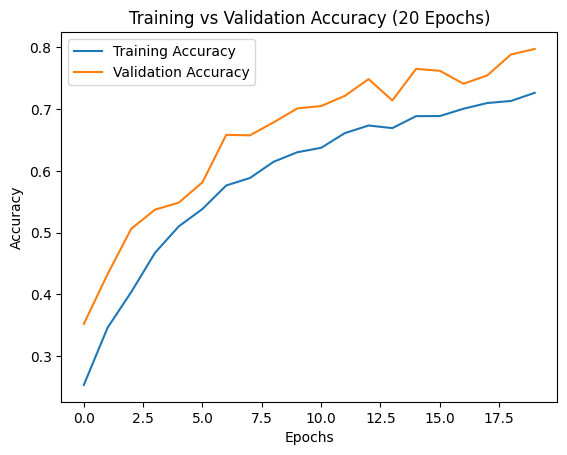

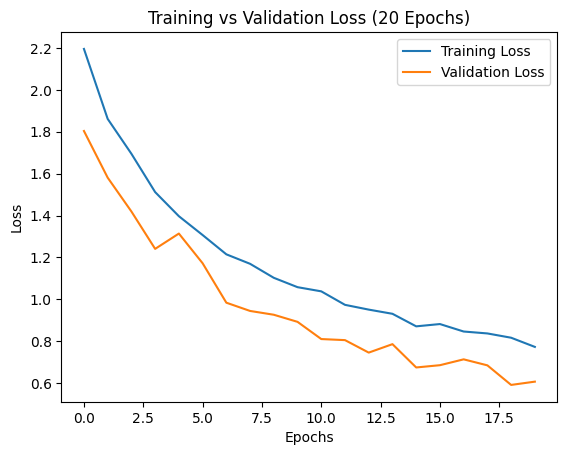

In [18]:
# Plot the training and validation accuracy for 20 epochs
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (20 Epochs)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss (20 Epochs)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
history2.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step
Classification Report (20 Epochs):
                  precision    recall  f1-score   support

         Healthy       0.15      0.15      0.15       129
bacterial blight       0.18      0.20      0.19       277
      brown spot       0.13      0.13      0.13       151
   fall armyworm       0.00      0.00      0.00        28
      grasshoper       0.00      0.00      0.00        68
      green mite       0.09      0.09      0.09       116
         healthy       0.00      0.00      0.00        20
     leaf beetle       0.07      0.06      0.06        94
     leaf blight       0.08      0.10      0.09       100
       leaf spot       0.09      0.09      0.09       125
          mosaic       0.11      0.09      0.10       124
    streak virus       0.07      0.06      0.07       100

        accuracy                           0.11      1332
       macro avg       0.08      0.08      0.08      1332
    weighted avg       0.11      0.11      0.11     

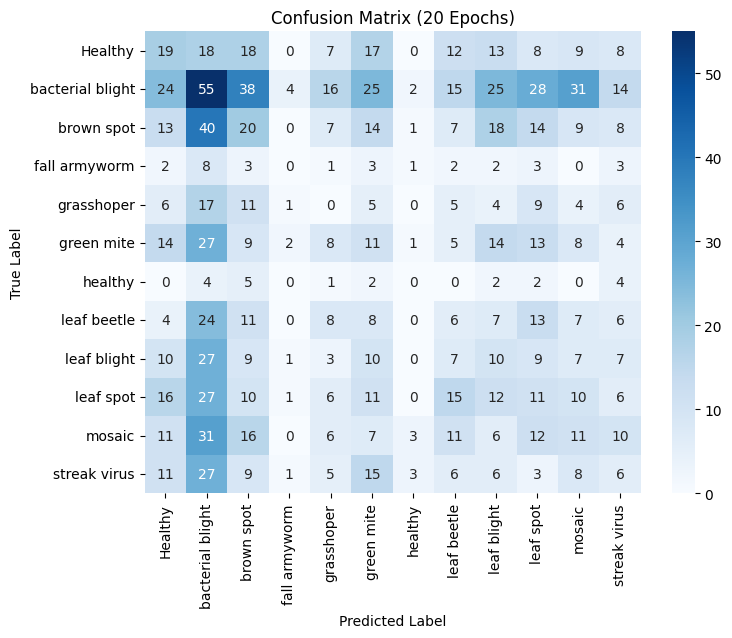

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Get the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Class labels

# Predict on the test set using model2 (the 20-epoch model)
predictions = model2.predict(test_generator)  # Changed to model2
predicted_classes = np.argmax(predictions, axis=1)

# Generate classification report
print("Classification Report (20 Epochs):")  # Added "(20 Epochs)" for clarity
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (20 Epochs)")  # Added "(20 Epochs)" for clarity
plt.show()

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Data generators to load and augment images in batches
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Assuming you have a function `flow_from_dataframe()` to load images from the DataFrame
# If your DataFrame contains the image paths and classes, you can use it in ImageDataGenerator.
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df, directory=None,
                                                    x_col='image_path', y_col='class',
                                                    target_size=(150, 150), batch_size=32,
                                                    class_mode='categorical')

valid_generator = valid_datagen.flow_from_dataframe(dataframe=valid_df, directory=None,
                                                    x_col='image_path', y_col='class',
                                                    target_size=(150, 150), batch_size=32,
                                                    class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(dataframe=test_df, directory=None,
                                                  x_col='image_path', y_col='class',
                                                  target_size=(150, 150), batch_size=32,
                                                  class_mode='categorical')

# Build the CNN Model
model3= Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_df['class'].unique()), activation='softmax')  # Number of classes
])

# Compile the model
model3.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Define a checkpoint to save the best model during training
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Train the model
history3 = model3.fit(train_generator, epochs=30, validation_data=valid_generator,
                    callbacks=[checkpoint])

# Evaluate the model on the test set
test_loss, test_accuracy = model3.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.4f}")

Found 10648 validated image filenames belonging to 12 classes.
Found 1331 validated image filenames belonging to 12 classes.
Found 1332 validated image filenames belonging to 12 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.1960 - loss: 2.3160
Epoch 1: val_loss improved from inf to 1.86948, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 156s 465ms/step - accuracy: 0.1961 - loss: 2.3157 - val_accuracy: 0.3418 - val_loss: 1.8695
Epoch 2/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.3284 - loss: 1.9497
Epoch 2: val_loss improved from 1.86948 to 1.72205, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 156s 467ms/step - accuracy: 0.3285 - loss: 1.9496 - val_accuracy: 0.3614 - val_loss: 1.7220
Epoch 3/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.3873 - loss: 1.7482
Epoch 3: val_loss improved from 1.72205 to 1.49237, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 152s 457ms/step - accuracy: 0.3874 - loss: 1.7481 - val_accuracy: 0.4688 - val_loss: 1.4924
Epoch 4/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.4506 - loss: 1.5541
Epoch 4: val_loss improved from 1.49237 to 1.32045, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 152s 457ms/step - accuracy: 0.4506 - loss: 1.5541 - val_accuracy: 0.5327 - val_loss: 1.3205
Epoch 5/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.4941 - loss: 1.4568
Epoch 5: val_loss improved from 1.32045 to 1.18762, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 150s 450ms/step - accuracy: 0.4941 - loss: 1.4567 - val_accuracy: 0.5823 - val_loss: 1.1876
Epoch 6/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.5490 - loss: 1.2930
Epoch 6: val_loss improved from 1.18762 to 1.08430, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 154s 461ms/step - accuracy: 0.5490 - loss: 1.2930 - val_accuracy: 0.6138 - val_loss: 1.0843
Epoch 7/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.5956 - loss: 1.1751
Epoch 7: val_loss did not improve from 1.08430
333/333 ━━━━━━━━━━━━━━━━━━━━ 154s 462ms/step - accuracy: 0.5956 - loss: 1.1752 - val_accuracy: 0.6198 - val_loss: 1.1514
Epoch 8/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.5945 - loss: 1.1570
Epoch 8: val_loss improved from 1.08430 to 0.90598, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 155s 466ms/step - accuracy: 0.5945 - loss: 1.1570 - val_accuracy: 0.6912 - val_loss: 0.9060
Epoch 9/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.6259 - loss: 1.0771
Epoch 9: val_loss improved from 0.90598 to 0.81979, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 150s 451ms/step - accuracy: 0.6259 - loss: 1.0771 - val_accuracy: 0.7115 - val_loss: 0.8198
Epoch 10/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.6354 - loss: 1.0454
Epoch 10: val_loss did not improve from 0.81979
333/333 ━━━━━━━━━━━━━━━━━━━━ 150s 450ms/step - accuracy: 0.6354 - loss: 1.0454 - val_accuracy: 0.6724 - val_loss: 0.9592
Epoch 11/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.6509 - loss: 1.0122
Epoch 11: val_loss improved from 0.81979 to 0.80466, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 154s 462ms/step - accuracy: 0.6509 - loss: 1.0121 - val_accuracy: 0.7183 - val_loss: 0.8047
Epoch 12/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.6544 - loss: 0.9739
Epoch 12: val_loss improved from 0.80466 to 0.72679, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 149s 448ms/step - accuracy: 0.6544 - loss: 0.9739 - val_accuracy: 0.7431 - val_loss: 0.7268
Epoch 13/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.6697 - loss: 0.9423
Epoch 13: val_loss did not improve from 0.72679
333/333 ━━━━━━━━━━━━━━━━━━━━ 149s 446ms/step - accuracy: 0.6697 - loss: 0.9423 - val_accuracy: 0.7513 - val_loss: 0.7392
Epoch 14/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.6969 - loss: 0.8679
Epoch 14: val_loss improved from 0.72679 to 0.64652, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 151s 452ms/step - accuracy: 0.6969 - loss: 0.8679 - val_accuracy: 0.7626 - val_loss: 0.6465
Epoch 15/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.7087 - loss: 0.8316
Epoch 15: val_loss improved from 0.64652 to 0.64416, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 151s 453ms/step - accuracy: 0.7087 - loss: 0.8317 - val_accuracy: 0.7769 - val_loss: 0.6442
Epoch 16/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.7008 - loss: 0.8433
Epoch 16: val_loss did not improve from 0.64416
333/333 ━━━━━━━━━━━━━━━━━━━━ 151s 454ms/step - accuracy: 0.7008 - loss: 0.8433 - val_accuracy: 0.7528 - val_loss: 0.6810
Epoch 17/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.7163 - loss: 0.7983
Epoch 17: val_loss improved from 0.64416 to 0.64218, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 152s 458ms/step - accuracy: 0.7163 - loss: 0.7983 - val_accuracy: 0.7678 - val_loss: 0.6422
Epoch 18/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.7204 - loss: 0.7864
Epoch 18: val_loss improved from 0.64218 to 0.63735, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 149s 446ms/step - accuracy: 0.7204 - loss: 0.7865 - val_accuracy: 0.7724 - val_loss: 0.6373
Epoch 19/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.7360 - loss: 0.7562
Epoch 19: val_loss improved from 0.63735 to 0.60473, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 151s 451ms/step - accuracy: 0.7360 - loss: 0.7563 - val_accuracy: 0.7859 - val_loss: 0.6047
Epoch 20/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.7218 - loss: 0.7811
Epoch 20: val_loss did not improve from 0.60473
333/333 ━━━━━━━━━━━━━━━━━━━━ 150s 449ms/step - accuracy: 0.7218 - loss: 0.7811 - val_accuracy: 0.7596 - val_loss: 0.6675
Epoch 21/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.7411 - loss: 0.7428
Epoch 21: val_loss did not improve from 0.60473
333/333 ━━━━━━━━━━━━━━━━━━━━ 152s 457ms/step - accuracy: 0.7411 - loss: 0.7428 - val_accuracy: 0.7641 - val_loss: 0.7157
Epoch 22/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.7503 - loss: 0.7117
Epoch 22: val_loss did not improve from 0.60473
333/333 ━━━━━━━━━━━━━━━━━━━━ 149s 446ms/step - accuracy: 0.7503 - loss: 0.7117 - val_accuracy: 0.7596 - val_loss: 0.7045
Epoch 23/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.7307 - loss: 0.7577
Epoch 23: val_lo

333/333 ━━━━━━━━━━━━━━━━━━━━ 147s 441ms/step - accuracy: 0.7307 - loss: 0.7576 - val_accuracy: 0.7971 - val_loss: 0.5940
Epoch 24/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.7473 - loss: 0.7286
Epoch 24: val_loss improved from 0.59397 to 0.58527, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 150s 450ms/step - accuracy: 0.7473 - loss: 0.7285 - val_accuracy: 0.7844 - val_loss: 0.5853
Epoch 25/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.7442 - loss: 0.7073
Epoch 25: val_loss improved from 0.58527 to 0.55757, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 154s 461ms/step - accuracy: 0.7442 - loss: 0.7073 - val_accuracy: 0.7994 - val_loss: 0.5576
Epoch 26/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.7626 - loss: 0.6844
Epoch 26: val_loss improved from 0.55757 to 0.55131, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 152s 455ms/step - accuracy: 0.7625 - loss: 0.6845 - val_accuracy: 0.8017 - val_loss: 0.5513
Epoch 27/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.7625 - loss: 0.6620
Epoch 27: val_loss improved from 0.55131 to 0.54598, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 152s 455ms/step - accuracy: 0.7625 - loss: 0.6621 - val_accuracy: 0.8054 - val_loss: 0.5460
Epoch 28/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.7646 - loss: 0.6519
Epoch 28: val_loss did not improve from 0.54598
333/333 ━━━━━━━━━━━━━━━━━━━━ 156s 469ms/step - accuracy: 0.7646 - loss: 0.6519 - val_accuracy: 0.8009 - val_loss: 0.5920
Epoch 29/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.7707 - loss: 0.6449
Epoch 29: val_loss improved from 0.54598 to 0.52845, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 153s 459ms/step - accuracy: 0.7707 - loss: 0.6450 - val_accuracy: 0.8092 - val_loss: 0.5284
Epoch 30/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.7535 - loss: 0.6811
Epoch 30: val_loss improved from 0.52845 to 0.50440, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 154s 463ms/step - accuracy: 0.7536 - loss: 0.6811 - val_accuracy: 0.8227 - val_loss: 0.5044
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - accuracy: 0.8045 - loss: 0.5626
Test accuracy: 0.8183


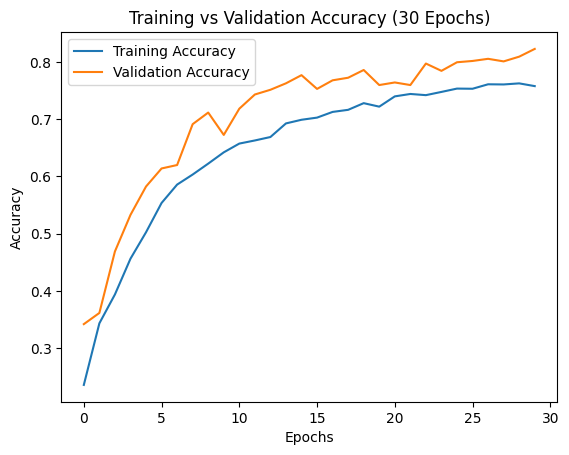

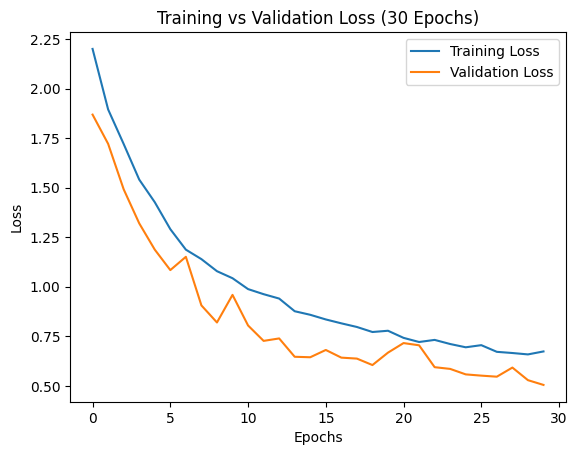

In [22]:
# Plot the training and validation accuracy for 30 epochs
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (30 Epochs)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss for 30 epochs
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss (30 Epochs)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
history3.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step
Classification Report (30 Epochs):
                  precision    recall  f1-score   support

         Healthy       0.12      0.11      0.11       129
bacterial blight       0.19      0.22      0.20       277
      brown spot       0.09      0.09      0.09       151
   fall armyworm       0.00      0.00      0.00        28
      grasshoper       0.03      0.03      0.03        68
      green mite       0.09      0.09      0.09       116
         healthy       0.00      0.00      0.00        20
     leaf beetle       0.07      0.06      0.06        94
     leaf blight       0.08      0.08      0.08       100
       leaf spot       0.12      0.14      0.13       125
          mosaic       0.08      0.08      0.08       124
    streak virus       0.07      0.07      0.07       100

        accuracy                           0.11      1332
       macro avg       0.08      0.08      0.08      1332
    weighted avg       0.11      0.11      0.11     

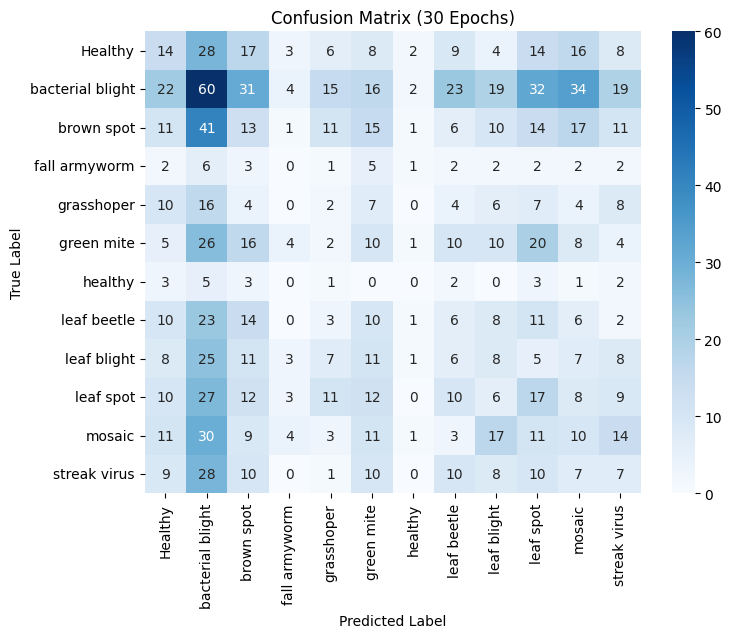

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Get the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Class labels

# Predict on the test set using model3 (the 30-epoch model)
predictions = model3.predict(test_generator)  # Changed to model3
predicted_classes = np.argmax(predictions, axis=1)

# Generate classification report
print("Classification Report (30 Epochs):")  # Added "(30 Epochs)" for clarity
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (30 Epochs)")  # Added "(30 Epochs)" for clarity
plt.show()